In [1]:
import scipy.io
import mne
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import spectrogram
from scipy.stats import entropy, skew
from scipy.linalg import toeplitz, cholesky
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

D:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
D:\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [10]:
# 1. 导入MAT文件
mat_data = scipy.io.loadmat('data/indy_20160407_02.mat')
mat_data1 = scipy.io.loadmat('data/indy_20161006_02.mat')

In [3]:
print(type(mat_data))
for k,v in mat_data.items():
    print(f"{k}，{type(v)}")

<class 'dict'>
__header__，<class 'bytes'>
__version__，<class 'str'>
__globals__，<class 'list'>
chan_names，<class 'numpy.ndarray'>
cursor_pos，<class 'numpy.ndarray'>
finger_pos，<class 'numpy.ndarray'>
spikes，<class 'numpy.ndarray'>
t，<class 'numpy.ndarray'>
target_pos，<class 'numpy.ndarray'>
wf，<class 'numpy.ndarray'>


In [4]:
# 提取数据
chan_names = mat_data['chan_names'].flatten()  #通道数96
chan_names=np.array([k[0] for k in chan_names])
cursor_pos = mat_data['cursor_pos']  #光标的位置
finger_pos = mat_data['finger_pos']  #指尖
spikes = mat_data['spikes']          #神经数据：unsorted/sorted
t = mat_data['t'].flatten()          #采样时间戳
target_pos = mat_data['target_pos']  #目标出现的xy
wf = mat_data['wf']                  #每个通道神经元发放波形

In [5]:
print(chan_names.shape)
print(cursor_pos.shape)
print(finger_pos.shape)
print(spikes.shape)
print(t.shape)
print(target_pos.shape)
print(wf.shape)

(192,)
(204446, 2)
(204446, 3)
(192, 3)
(204446,)
(204446, 2)
(192, 3)


In [6]:
m,n=spikes.shape
print(m,n)
print(spikes.shape)

192 3
(192, 3)


In [7]:
m,n=spikes.shape
result=[]
number=np.zeros(11)
for row in range(m):
    for col in range(n):
        spike_times=spikes[row,col][:,:].flatten()
        if len(spike_times)>100:
            hist, bins = np.histogram(spike_times, bins=np.arange(min(spike_times),max(spike_times), 5))

            # 这里是目标和光标位置的xy差距的平均值，对应于
            a1=abs(target_pos[:,0]-cursor_pos[:,0])
            a2=abs(target_pos[:,1]-cursor_pos[:,1])
            averages1 = []
            averages2 = []
            len_tt=int(len(a1)/(len(hist)-1))
            for i in range(0, len(a1), len_tt):
                avg1 = np.mean(a1[i:i+len_tt])
                avg2 = np.mean(a2[i:i+len_tt])
                averages1.append(avg1)
                averages2.append(avg2)

            # 使用numpy.vstack函数在行方向上连接两个自变量
            X_combined = np.vstack((averages1, averages2)).T
            model = LinearRegression()

            # 拟合模型
            model.fit(X_combined,hist)
            y_pred = model.predict(X_combined)
            r_squared = r2_score(hist, y_pred)
            result.append(r_squared)
            if r_squared>0.5:
                number[10]+=1
            else:
#                 print(r_squared,r_squared/0.05)
                number[int(r_squared/0.05)]+=1
number=number/sum(number)
print(number)

[0.87581699 0.09477124 0.01960784 0.00980392 0.         0.
 0.         0.         0.         0.         0.        ]


In [11]:
chan_names = mat_data1['chan_names'].flatten()  #通道数96
chan_names=np.array([k[0] for k in chan_names])
cursor_pos = mat_data1['cursor_pos']  #光标的位置
finger_pos = mat_data1['finger_pos']  #指尖
spikes = mat_data1['spikes']          #神经数据：unsorted/sorted
t = mat_data1['t'].flatten()          #采样时间戳
target_pos = mat_data1['target_pos']  #目标出现的xy
wf = mat_data1['wf']                  #每个通道神经元发放波形

In [12]:
m,n=spikes.shape
result=[]
number1=np.zeros(11)
for row in range(m):
    for col in range(n):
        spike_times=spikes[row,col][:,:].flatten()
        if len(spike_times)>100:
            hist, bins = np.histogram(spike_times, bins=np.arange(min(spike_times),max(spike_times), 5))

            # 这里是目标和光标位置的xy差距的平均值，对应于
            a1=abs(target_pos[:,0]-cursor_pos[:,0])
            a2=abs(target_pos[:,1]-cursor_pos[:,1])
            averages1 = []
            averages2 = []
            len_tt=int(len(a1)/(len(hist)-1))
            for i in range(0, len(a1), len_tt):
                avg1 = np.mean(a1[i:i+len_tt])
                avg2 = np.mean(a2[i:i+len_tt])
                averages1.append(avg1)
                averages2.append(avg2)

            # 使用numpy.vstack函数在行方向上连接两个自变量
            X_combined = np.vstack((averages1, averages2)).T
            model = LinearRegression()

            # 拟合模型
            model.fit(X_combined,hist)
            y_pred = model.predict(X_combined)
            r_squared = r2_score(hist, y_pred)
            result.append(r_squared)
            if r_squared>0.5:
                number1[10]+=1
            else:
#                 print(r_squared,r_squared/0.05)
                number1[int(r_squared/0.05)]+=1
number1=number1/sum(number1)
print(number1)

[0.45493562 0.27467811 0.15021459 0.06008584 0.03862661 0.00858369
 0.01287554 0.         0.         0.         0.        ]


[0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525]


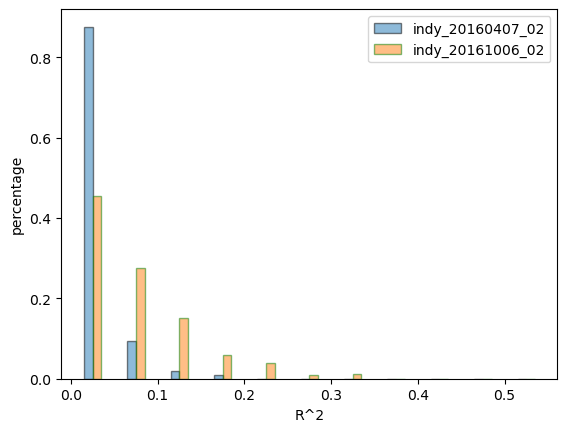

In [13]:
# 指定区间边界
bins =np.arange(0.025,0.575,0.05)
print(bins)

# 创建直方图
plt.bar(bins-0.005,number,width=0.01,edgecolor='k', alpha=0.5, label='indy_20160407_02')

plt.bar(bins+0.005,number1,width=0.01,edgecolor='g', alpha=0.5, label='indy_20161006_02')
# 添加标签和标题
plt.xlabel('R^2')
plt.ylabel('percentage')
# plt.title('直方图示例')
plt.legend()

# 显示图形
plt.show()